In [1]:
from pathlib import Path
import numpy as np
from datetime import datetime
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import pandas as pd
import glob

import gdal
import cmocean
import cmaps
import regionmask

import os

from skgstat import Variogram, OrdinaryKriging
plt.style.use('ggplot')
os.environ['SKG_SUPPRESS'] = "true"

In [2]:
# function to remove outliers from every single along track

def remove_outliers(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname)
    
    #select all the required variables to detect only the valid data
    df2 = df2[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
    
    # convert to pandas dataframe
    df2 = df2.to_dataframe()
    df2.reset_index(inplace=True)
    
        # apply the filtering criteria
    df2 = df2[(df2['surface_type'] == 0.) & (df2['ice_flag'] == 0.) & (df2['swh'] < 30.) & (df2['sig0'] < 30.) & (df2['sig0'] > 3.) \
            & (df2['off_nadir_angle_wf'] < 0.0625) & (df2['off_nadir_angle_wf'] > -0.2) & (df2['wind_speed_alt'] < 30) & \
             (df2['sig0_rms'] < 1) & (df2['range_rms'] < 0.2) & (df2['swh_numval'] > 20) & (df2['swh_rms'] < df2['swh'])]
    
    
    # remove outliers from significant wave height
    q1 = df2['swh'].quantile(0.25)
    q3 = df2['swh'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    outliers_removed = df2.loc[(df2['swh'] > fence_low) & (df2['swh'] < fence_high)]
    
    """
    
    #use the standard deviation method
    
    # calculate summary statistics
    data_mean, data_std = np.mean(df2['swh']), np.std(df2['swh'])
    #identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # remove outliers
    outliers_removed = df2.loc[(df2['swh'] > lower) & (df2['swh'] < upper)]
    

    
    #remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    """

    return outliers_removed

In [3]:
# import all data files
p = Path('C:/Users/panmits86/Desktop/SA_val_2')

results = []
for fname in p.glob('*.nc'):
    swh_sa = remove_outliers(fname)
    results.append(swh_sa)
    swh = pd.concat(results)

In [4]:
swh_sa = swh[['time','lon','lat','swh','wind_speed_alt']]
swh_sa = swh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa

,time,lon,lat,swh,wind_speed_alt
0,2016-07-07 10:14:49.624763008,289.648891,40.191881,1.013,1.13
1,2016-07-07 10:14:52.742073088,289.588603,40.374652,1.090,1.35
2,2016-07-07 10:14:53.781178944,289.568450,40.435571,0.786,1.17
3,2016-07-07 10:14:54.820281984,289.548268,40.496486,0.979,1.23
4,2016-07-07 10:14:55.859388096,289.528058,40.557399,1.097,1.50
...,...,...,...,...,...
5829,2019-12-22 10:22:46.047041920,286.145365,40.025461,0.576,4.69
5830,2019-12-22 10:22:47.084560896,286.125404,40.086325,0.296,4.74
5831,2019-12-22 10:22:48.122082176,286.105414,40.147186,0.407,4.58
5832,2019-12-22 10:22:49.159601152,286.085398,40.208044,0.489,4.26


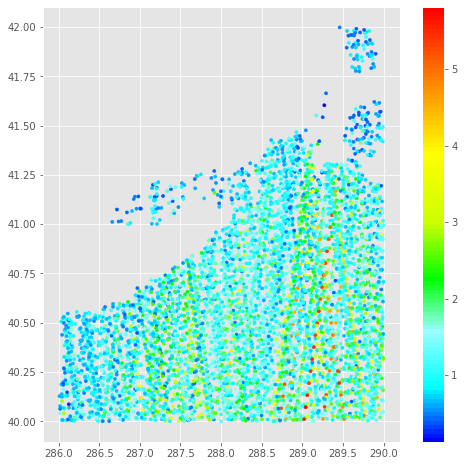

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,8)) 
art = ax.scatter(swh_sa['lon'],swh_sa['lat'], s=10, c=swh_sa['swh'], cmap=cmaps.BlAqGrYeOrRe) 
plt.colorbar(art);

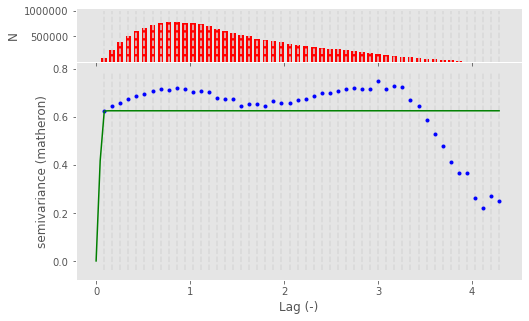

In [7]:
V = Variogram(swh_sa[['lon', 'lat']].values, swh_sa['swh'].values, model='spherical', normalize=False, n_lags=50)
fig = V.plot(show=False)

In [8]:
print('Sample variance: %.2f Variogram sill: %.2f ' % (swh_sa['swh'].var(), V.describe()['sill']))

Sample variance: 0.69 Variogram sill: 0.63 


In [9]:
pprint(V.describe())

Pretty printing has been turned OFF


In [10]:
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   0.09
Sill:              0.63
Nugget:            0.00
        


In [11]:
ok = OrdinaryKriging(V, max_points=600, mode='exact')

In [12]:
# build the target grid 
xx, yy = np.mgrid[-74:-70:40j, 40:42:20j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape) 
s2 = ok.sigma.reshape(xx.shape)

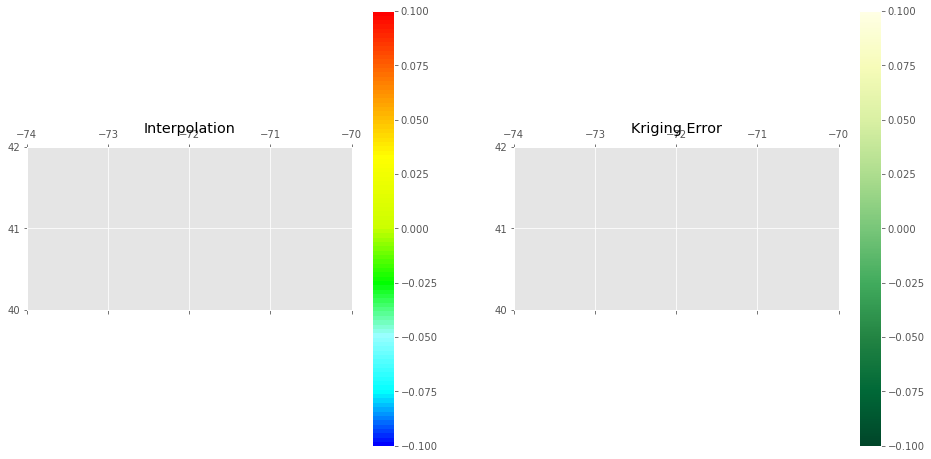

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 
art = axes[0].matshow(field.T, origin='lower', cmap=cmaps.BlAqGrYeOrRe) 
axes[0].set_title('Interpolation') 
#axes[0].plot(swh_sa['lon'], swh_sa['lat'], '+k') 
axes[0].set_xlim((-74,-70)) 
axes[0].set_ylim((40,42)) 
plt.colorbar(art, ax=axes[0]) 
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r') 
axes[1].set_title('Kriging Error') 
plt.colorbar(art, ax=axes[1]) 
#axes[1].plot(swh_sa['lon'], swh_sa['lat'], '+w') 
axes[1].set_xlim((-74,-70)) 
axes[1].set_ylim((40,42));